<a href="https://colab.research.google.com/github/FelipeFerAl/SignalsTheory/blob/main/TrabajoLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Librerias y Señal Original

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from keras.activations import relu, linear
from tensorflow.keras.optimizers import Adam

In [ ]:
#Frecuencia angular general y vector de tiempo
w = 2*np.pi
T = 3
N = 1024
fs = N/T
t = np.linspace(0,T,N)

#Señales particulares
x1 = np.cos(w*t)
x2 = 1/3*(np.sin(3*w*t))
x3 = 1/5*(np.sin(5*w*t))

#Señal original para la red
xt = x1-x2+x3

#Transformada de la señal original
fr, xt_trans = sig.welch(xt,fs=fs,nperseg=1024)

# Función generadora de ruido
En base a esta función podremos crear señales aleatorias con diferentes niveles de ruido

In [ ]:
def noise_generator(ruidos=[0.1,0.3,1,3,10,30], size=1024, señales=200):
  H = []
  for ruido in ruidos:
    for i in range(señales):
      noise = np.random.normal(0,ruido,size)
      noisy_signal = xt + noise
      H.append(noisy_signal)
  return np.array(H)

# Generación de la matriz de entrada y salida y preparación de los datos
Generamos la matriz de entrada con la función de ruido, luego transformamos esta misma matriz con el método de Welch y obtenemos la matriz que funcionará como la salida de mi modelo

In [ ]:
M_ruido = noise_generator()
PSD = sig.welch(M_ruido,fs=fs,nperseg=1024)[1]

In [ ]:
PSD_prom = np.mean(PSD,axis=0)
PSD_prom2 = np.tile(PSD_prom,(1200,1))

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(M_ruido, PSD_prom2, test_size=0.3, random_state=50)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Definición del modelo

In [ ]:
model=Sequential()
model.add(LSTM(64,input_shape=(1024,1),return_sequences=False))
model.add(Dense(513,activation='linear'))

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt,loss='mae',metrics=['accuracy','mse'])

history=model.fit(x_train,y_train,epochs=10,validation_split=0.2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 430ms/step - accuracy: 0.0000e+00 - loss: 0.9892 - mse: 0.9869 - val_accuracy: 0.0000e+00 - val_loss: 0.9824 - val_mse: 0.9733
Epoch 2/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 371ms/step - accuracy: 0.0000e+00 - loss: 0.9796 - mse: 0.9680 - val_accuracy: 0.0000e+00 - val_loss: 0.9697 - val_mse: 0.9488
Epoch 3/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 411ms/step - accuracy: 0.0000e+00 - loss: 0.9646 - mse: 0.9391 - val_accuracy: 0.0000e+00 - val_loss: 0.9425 - val_mse: 0.8978
Epoch 4/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 444ms/step - accuracy: 0.0000e+00 - loss: 0.9248 - mse: 0.8665 - val_accuracy: 0.0000e+00 - val_loss: 0.8159 - val_mse: 0.6884
Epoch 5/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 378ms/step - accuracy: 0.0000e+00 - loss: 0.7402 - mse: 0.5868 - val_accuracy: 0.0000e+00 - val_loss: 0.5071 - val_mse: 0.3197
Epoch 6/10
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 371ms/step - accuracy: 0.0000e+00 - loss: 0.4460 - mse: 0.2650 - val_accuracy: 0.0000e+00 - val_loss: 0.2923 - val_mse: 0.1402


# Estimación

In [ ]:
model.evaluate(x_test,y_test)

y = model.predict(x_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - accuracy: 1.0000 - loss: 0.0163 - mse: 0.0041
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step


# Modelo umbral

In [ ]:
#@title Función umbral
def umbral(signal):
  percentile_threshold = 95
  threshold = np.percentile(signal, percentile_threshold)

  # Visualizar el histograma y el umbral
  plt.figure(figsize=(16, 5))
  plt.hist(signal, bins=50, alpha=0.7, label='Predicción')
  plt.axvline(threshold, color='r', linestyle='dashed', linewidth=2, label=f'Umbral ({percentile_threshold}%)')
  plt.legend()
  plt.show()

  #Visualizar el umbral en la señal predicha
  plt.figure(figsize=(16,5))
  plt.plot(fr,signal,label='Prediccion')
  plt.axhline(y=threshold, color='r', linestyle='--', label=f'Umbral({percentile_threshold}%)')
  plt.xlabel('Frequency')
  plt.xlim(0,10)
  plt.xticks(np.arange(0,10,1))
  plt.legend()
  plt.show()

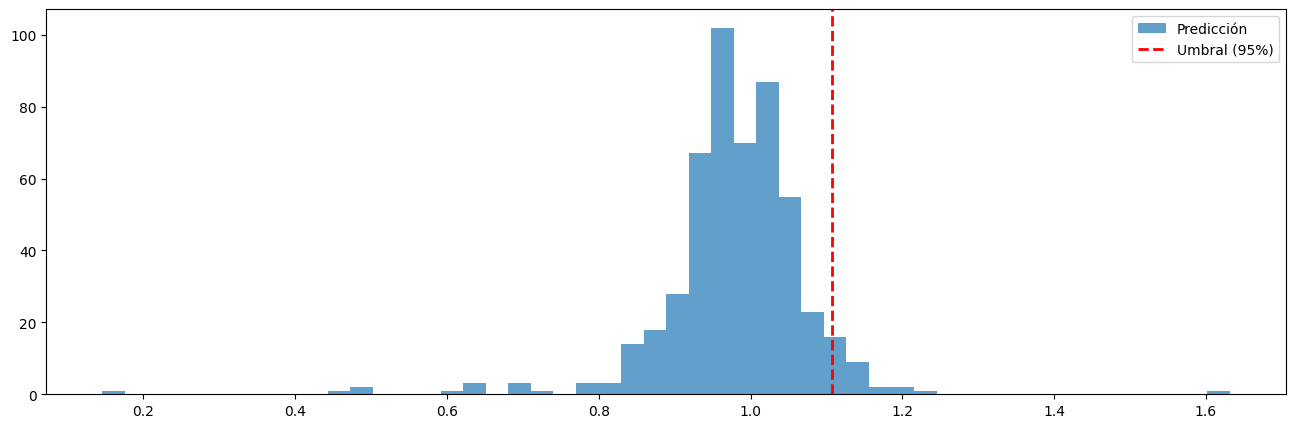

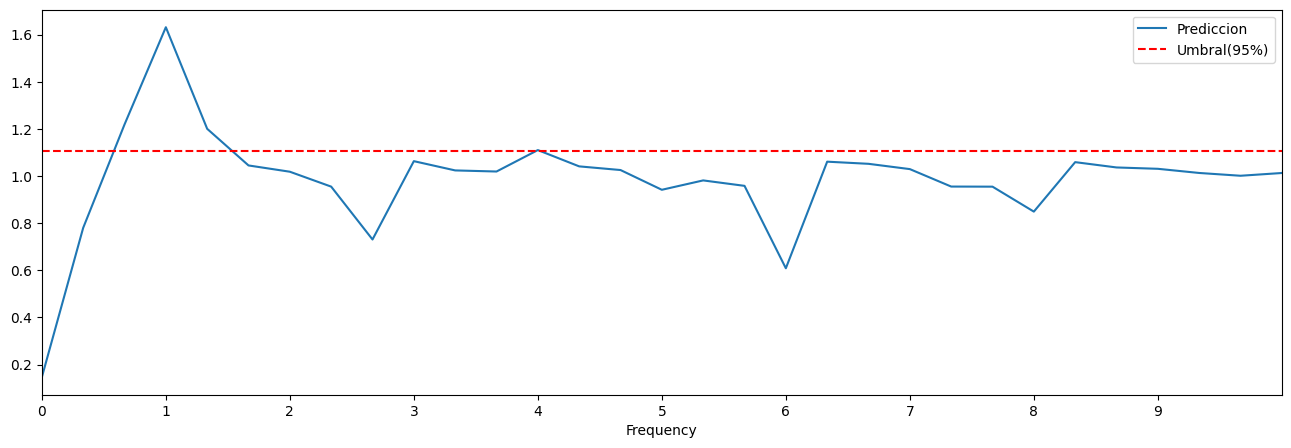

In [ ]:
umbral(y[200])

# Regreso al dominio del tiempo
Conociendo las frecuencias de los armónicos hallamos la amplitud y pintamos una nueva señal reconstruida para comparar

In [ ]:
point = int(input("Ingrese la señal que desea analizar (0-297): "))

potencia1=y[point][np.argmin(np.abs(fr - 1))]     #Armónico en 1Hz
print(f'En el armonico 1 la potencia es {potencia1}')

potencia2=y[point][np.argmin(np.abs(fr - 3))]     #Armónico en 3Hz
print(f'En el armonico 2 la potencia es {potencia2}')


potencia3=y[point][np.argmin(np.abs(fr - 5))]     #Armónico en 5Hz
print(f'En el armonico 3 la potencia es {potencia3}')

Ingrese la señal que desea analizar (0-297): 200
En el armonico 1 la potencia es 1.6312782764434814
En el armonico 2 la potencia es 1.0629956722259521
En el armonico 3 la potencia es 0.9415168166160583


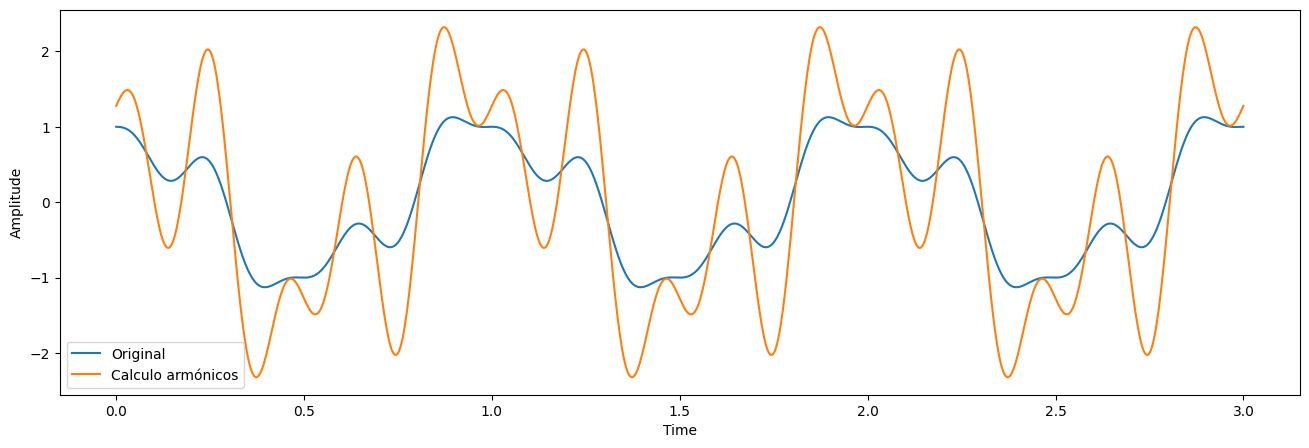

In [ ]:
#Señales particulares
x1_2 = np.sqrt(np.abs(potencia1))*np.cos(w*t)
x2_2 = np.sqrt(np.abs(potencia2))*(np.sin(3*w*t))
x3_2 = np.sqrt(np.abs(potencia3))*(np.sin(5*w*t))

xt_2 = x1_2 - x2_2 + x3_2

plt.figure(figsize=(16,5))
plt.plot(t,xt,label='Original')
plt.plot(t,xt_2,label='Calculo armónicos')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

Sin conocer las frecuencias de los armónicos, hallamos los 3 puntos más altos de la señal para pintar una nueva reconstrucción y comparar

In [ ]:
max1=y[point].max()
max2=0
max3=0
for i in range(0,len(fr)):
  if y[point][i] >= max1:
    max1 = y[point][i]
    fr1 = fr[i]
  elif y[point][i] >= max2:
    max2 = y[point][i]
    fr2 = fr[i]
  elif y[point][i] >= max3:
    max3 = y[point][i]
    fr3 = fr[i]

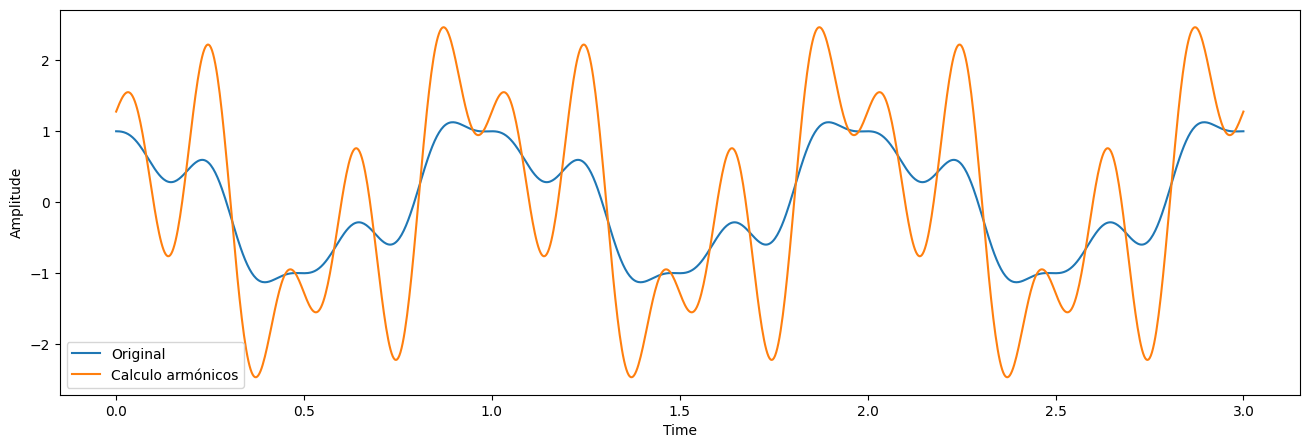

In [ ]:
x1_3 = np.sqrt(max1)*np.cos(w*t)
x2_3 = np.sqrt(max2)*(np.sin(3*w*t))
x3_3 = np.sqrt(max3)*(np.sin(5*w*t))

xt_3 = x1_3-x2_3+x3_3

plt.figure(figsize=(16,5))
plt.plot(t,xt,label='Original')
plt.plot(t,xt_3,label='Calculo armónicos')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

In [ ]:
mae1 = np.mean(np.abs(xt - xt_2))
print(f"Error Absoluto Medio 1: {mae1*100}")

mae2 = np.mean(np.abs(xt - xt_3))
print(f"Error Absoluto Medio 2: {mae2*100}")

mse1 = np.sqrt(np.mean((xt - xt_2)**2))
print(f"Error Cuadrático Medio 1: {mse1*100}")

mse2 = np.sqrt(np.mean((xt - xt_3)**2))
print(f"Error Cuadrático Medio 2: {mse2*100}")

Error Absoluto Medio 1: 62.94966098653148
Error Absoluto Medio 2: 70.58819359078008
Error Cuadrático Medio 1: 76.0269785585346
Error Cuadrático Medio 2: 85.82223703699078


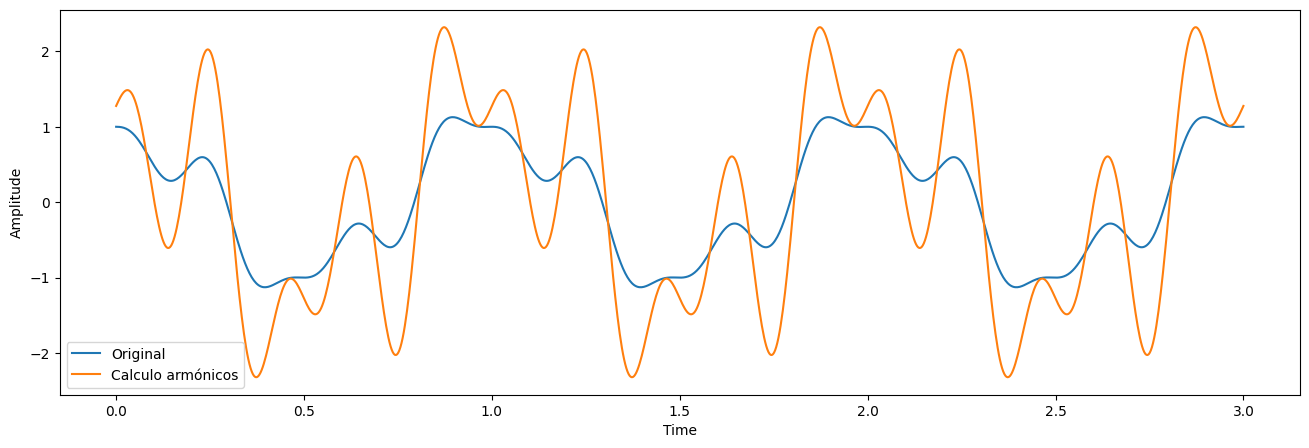

In [ ]:
for i in range(0,len(y)):
  prom=y[i][np.argmin(np.abs(fr - 1))]
  prom2=y[i][np.argmin(np.abs(fr - 3))]
  prom3=y[i][np.argmin(np.abs(fr - 5))]

x1_4 = np.sqrt(prom)*np.cos(w*t)
x2_4 = np.sqrt(prom2)*(np.sin(3*w*t))
x3_4 = np.sqrt(prom3)*(np.sin(5*w*t))

xt_4 = x1_4 - x2_4 + x3_4

plt.figure(figsize=(16,5))
plt.plot(t,xt,label='Original')
plt.plot(t,xt_4,label='Calculo armónicos')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Histograma predicciones por armónicos

In [ ]:
arm1 = []
arm2 = []
arm3 = []
for i in range(0,len(y)):
  arm1.append(y[i][np.argmin(np.abs(fr - 1))])
  arm2.append(y[i][np.argmin(np.abs(fr - 3))])
  arm3.append(y[i][np.argmin(np.abs(fr - 5))])

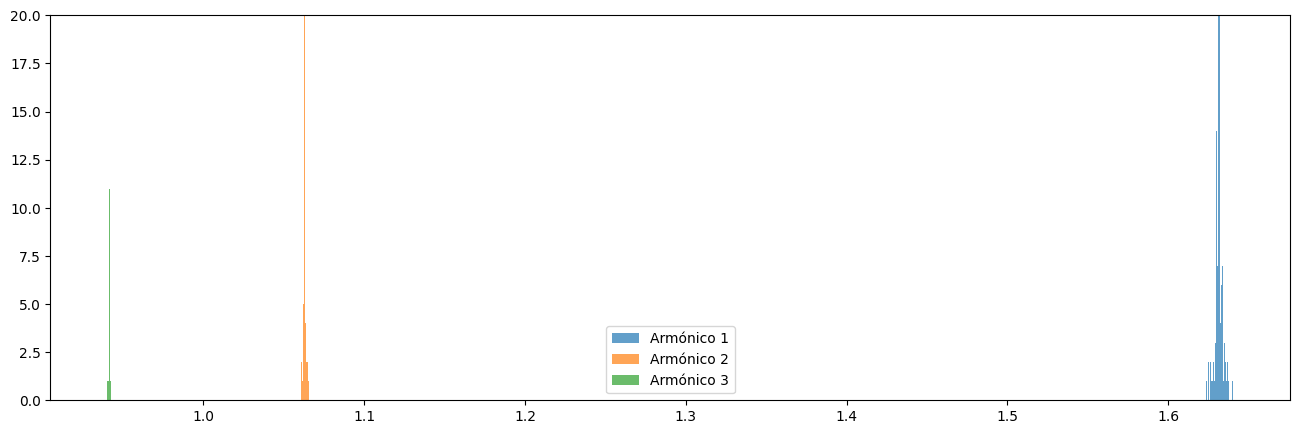

In [ ]:
plt.figure(figsize=(16,5))
plt.hist(arm1, bins=50, alpha=0.7, label='Armónico 1')
# plt.plot(x, p1, 'k', linewidth=2, label='Curva Gaussiana 1Hz')
plt.hist(arm2, bins=50, alpha=0.7, label='Armónico 2')
plt.hist(arm3, bins=50, alpha=0.7, label='Armónico 3')
plt.ylim(0,20)
plt.legend()
plt.show()

# Análisis




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          16,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 513)                 │          33,345 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 150,725 (588.77 KB)

 Trainable params: 50,241 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 100,484 (392.52 KB)

+----------+----------+----------+
|  Épocas  | MAE (L1) | MSE (L2) |
+----------+----------+----------+
|    1     |  0.9872  |  0.9829  |
|    2     |  0.9769  |  0.9627  |
|    3     |  0.9590  |  0.9286  |
|    4     |  0.9009  |  0.8259  |
|    5     |  0.6686  |  0.4989  |
|    6     |  0.3954  |  0.2222  |
|    7     |  0.2230  |  0.0968  |
|    8     |  0.1113  |  0.0415  |
|    9     |  0.0540  |  0.0175  |
|    10    |  0.0253  |  0.0070  |
| Promedio |  0.5302  |  0.4584  |
+----------+----------+----------+


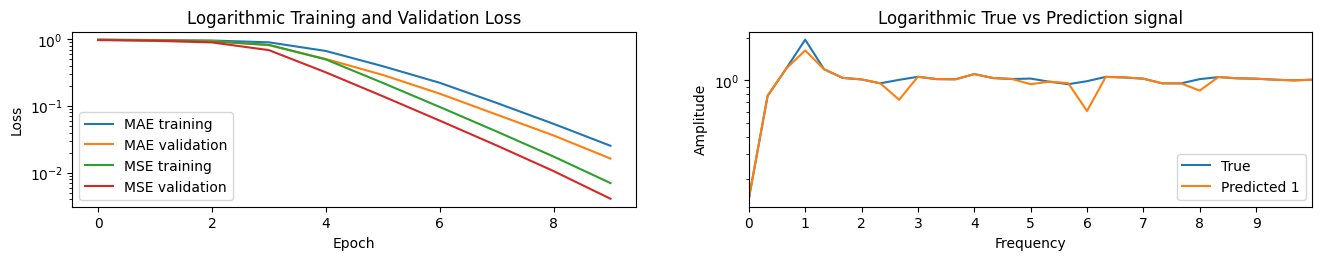

In [ ]:
#@title Código
model.summary()

from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Épocas','MAE (L1)','MSE (L2)']
for i in range(0,10):
  table.add_row([i+1,f"{history.history['loss'][i]:.4f}",f"{history.history['mse'][i]:.4f}"])
table.add_row(['Promedio',f"{np.mean(history.history['loss']):.4f}",f"{np.mean(history.history['mse']):.4f}"])
print(table)

plt.figure(figsize=(16,5))

plt.subplot(2,2,1)
plt.semilogy(history.history['loss'],label='MAE training')
plt.semilogy(history.history['val_loss'],label='MAE validation')
plt.semilogy(history.history['mse'],label='MSE training')
plt.semilogy(history.history['val_mse'],label='MSE validation')
plt.title('Logarithmic Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(2,2,2)
plt.semilogy(fr,y_test[50],label='True')
plt.semilogy(fr,y[200],label='Predicted 1')
plt.title('Logarithmic True vs Prediction signal')
plt.xlabel('Frequency')
plt.ylabel('Amplitude')
plt.xlim(0,10)
plt.xticks(np.arange(0,10,1))
plt.legend()

# plt.subplot(2,2,3)